<a href="https://colab.research.google.com/github/ShreejalBhattarai/Learning_MachineLearning/blob/main/resnet_dxa_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Shreejal Bhattarai**
--------------------------
Comparing ResNet18 with ResNet50 with data augumentation to train a medical image dataset to classify oestoporosis vs healthy bone using 540+ processed DXA images.

In [1]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
print("DIR original:", os.getcwd())
os.chdir('/content/drive/MyDrive/OP_Rolling_Ball_Imgs')
print("DIR working:", os.getcwd())
!ls

DIR original: /content
DIR working: /content/drive/.shortcut-targets-by-id/1xkxyRRm0fo6rCd_X8odxgL2KWqYeYYgr/OP_Rolling_Ball_Imgs
C1  C3


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import UnidentifiedImageError

class CleanImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except UnidentifiedImageError:
            # Skip bad image and try the next one
            return self.__getitem__((index + 1) % len(self))

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = CleanImageFolder(".", transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

images, labels = next(iter(loader))
print(images.shape, labels)


torch.Size([32, 3, 128, 128]) tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0])


In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(".", transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

images, labels = next(iter(loader))
print("Shape:", images.shape)
print("Labels:", labels)
print("Classes:", dataset.classes)


Shape: torch.Size([32, 3, 128, 128])
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 1])
Classes: ['C1', 'C3']


In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load the full dataset
full_dataset = datasets.ImageFolder(".", transform=transform)

# Split sizes
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

print(f"Train: {len(train_ds)} samples")
print(f"Val: {len(val_ds)} samples")
print(f"Test: {len(test_ds)} samples")


Train: 542 samples
Val: 116 samples
Test: 117 samples


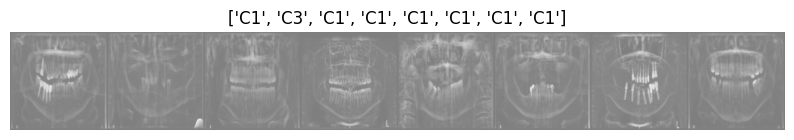

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Helper function to show images
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize if normalized
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get one batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]), title=[full_dataset.classes[i] for i in labels[:8]])


In [11]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [12]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1  # or .DEFAULT for the latest
model = resnet18(weights=weights)




Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


In [13]:
import torch.nn as nn
model.fc = nn.Linear(model.fc.in_features, 2)

model = model.to(device)


In [14]:
import torch.nn as nn
import torch.optim as optim

# 1. Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# 2. Define loss function
criterion = nn.CrossEntropyLoss()

# 3. Define optimizer (Adam with low learning rate for fine-tuning)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [15]:
num_epochs = 10
loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 0.7077
Epoch [2/10], Loss: 0.2617
Epoch [3/10], Loss: 0.1248
Epoch [4/10], Loss: 0.0749
Epoch [5/10], Loss: 0.0580
Epoch [6/10], Loss: 0.0570
Epoch [7/10], Loss: 0.0750
Epoch [8/10], Loss: 0.1028
Epoch [9/10], Loss: 0.0579
Epoch [10/10], Loss: 0.0253


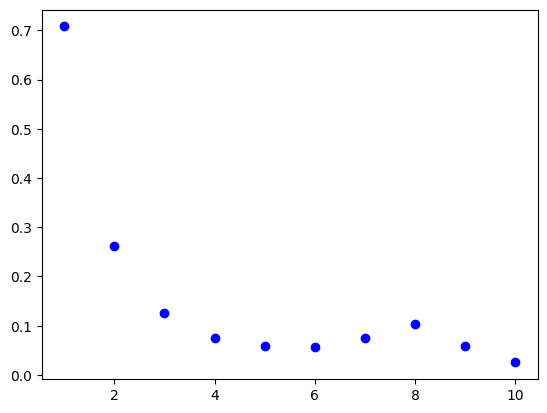

In [17]:
epochs = [1,2,3,4,5,6,7,8,9,10]
plt.scatter(epochs, loss_history, color='blue', marker='o', label='Data Points')

In [18]:
def evaluate(model, dataloader, name="Validation"):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"{name} Accuracy: {accuracy:.2f}%")

# Evaluate on validation and test sets
evaluate(model, val_loader, "Validation")
evaluate(model, test_loader, "Test")


Validation Accuracy: 94.83%
Test Accuracy: 87.18%


In [19]:
from sklearn.metrics import classification_report
import torch

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [20]:
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))


              precision    recall  f1-score   support

          C1       0.87      0.98      0.92        88
          C3       0.89      0.55      0.68        29

    accuracy                           0.87       117
   macro avg       0.88      0.76      0.80       117
weighted avg       0.87      0.87      0.86       117



In [21]:
import torch

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


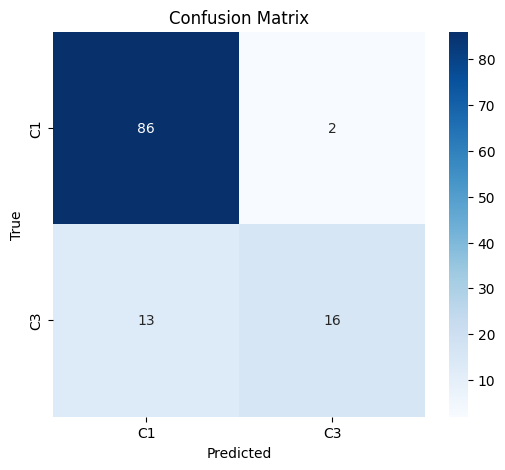

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
classes = full_dataset.classes  # ['C1', 'C3']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


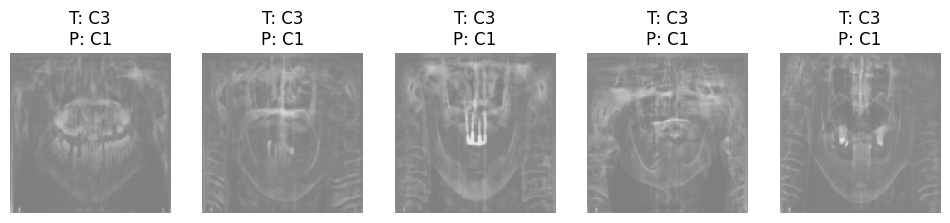

In [24]:
misclassified_indices = [i for i, (p, t) in enumerate(zip(all_preds, all_labels)) if p != t]

# Show first 5 misclassified images with their predicted and true labels
import torchvision

fig = plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassified_indices[:5]):
    img, true_label = test_ds[idx]
    pred_label = classes[all_preds[idx]]
    true_label_name = classes[all_labels[idx]]
    img = img / 2 + 0.5  # if normalized
    npimg = img.numpy()

    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(f"T: {true_label_name}\nP: {pred_label}")
    ax.axis('off')

plt.show()


Now, let's try using data augumentation. We'll be using V2 transforms from pytorch.transforms and we'll be making use of CUDA with tensors as the data type.


Also, let's use a deeper ResNet Model


In [35]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

preprocess = weights.transforms()

In [36]:
base_transforms = weights.transforms()

In [55]:
val_test_transform = transforms.Compose([
    transforms.ToTensor()
])

In [56]:
# Transforms for training (with augmentation)
from torchvision.transforms import v2

train_transform = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True), # Augmentation: Randomly crop and resize
    v2.RandomHorizontalFlip(),                            # Augmentation: Randomly flip horizontally
    v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3), # Augmentation: Randomly change color properties
    v2.ToTensor(),                                        # Converts PIL Image to FLoat Tensor (0.0-1.0) and reorders dims (HWC to CHW)
])



In [57]:
# Load the full dataset
full_dataset = datasets.ImageFolder(".", transform=train_transform)

# Split sizes
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

print(f"Train: {len(train_ds)} samples")
print(f"Val: {len(val_ds)} samples")
print(f"Test: {len(test_ds)} samples")


Train: 542 samples
Val: 116 samples
Test: 117 samples


In [ ]:
num_epochs = 10
loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 7.0980
Epoch [2/10], Loss: 7.0718


In [ ]:
epochs = [1,2,3,4,5,6,7,8,9,10]
plt.scatter(epochs, loss_history, color='blue', marker='o', label='Data Points')

In [ ]:
def evaluate(model, dataloader, name="Validation"):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"{name} Accuracy: {accuracy:.2f}%")

# Evaluate on validation and test sets
evaluate(model, val_loader, "Validation")
evaluate(model, test_loader, "Test")
